In [1]:


import time
import pickle
import logging
import argparse

import sys
import os
import numpy as np
import pandas as pd
import functools
import seaborn as sns

import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool 
from multiprocessing import Pool as ProcessPool 

from torch_geometric.data import Data
from torch_geometric.data import DataLoader

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Pick up local packages
sys.path.append('..')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import trackml.dataset

sys.path.append('/global/homes/c/caditi97/exatrkx-ctd2020/MetricLearning/src/preprocess_with_dir/')
# from extract_dir import *
from preprocess import get_one_event, load_detector

# Pick up local packages
sys.path.append('..')
sys.path.append('/global/homes/c/caditi97/exatrkx-ctd2020/MetricLearning/src/metric_learning_adjacent/')

# Local imports
from build_graphs import *
from GraphLearning.src.trainers import get_trainer
from utils.data_utils import (get_output_dirs, load_config_file, load_config_dir, load_summaries,
                      save_train_history, get_test_data_loader,
                      compute_metrics, save_metrics, draw_sample_xy)

from build_graphs import *
from tqdm import tqdm


In [2]:
def plot_noise(noise_hits,noise_truth,noise_keep,index):
    print("----" + str(noise_keep) + " Noise----")
    print("hits")
    print(noise_hits.shape)
    print("truth")
    print(noise_truth.shape)

    unique_ids = noise_truth.particle_id.unique()
    track_ids_to_keep = unique_ids[np.where(unique_ids != 0)]
    where_to_keep = noise_truth['particle_id'].isin(track_ids_to_keep)
    not_noise  = noise_hits[where_to_keep]
    noise = noise_hits[~where_to_keep]
    print("Not Noise Hits = " + str(len(not_noise)))
    print("Noise Hits = " + str(len(noise)))

    g3 = sns.jointplot(not_noise.x, not_noise.y, s=2, height=12, label = "not noise")
    g3.x = noise.x
    g3.y = noise.y
    g3.plot_joint(plt.scatter, c='r', s=1, label = "noise")



    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.legend()
    plt.title('Noise Distribution')
    plt.savefig('noise_[' +str(index)+ ']_' + str(noise_keep) + '.png', bbox_inches='tight')
    plt.show()

In [3]:
def plot_neighborhood(hits, truth, neighbors, noise_keep, k=None):
    print("----" + str(noise_keep) + " Noise----")
    print("hits")
    print(hits.shape)
    print("truth")
    print(truth.shape)
    
    hitidx = neighbors[k]
    hitids = hits.iloc[hitidx]['hit_id'].values
    print("len(neighbors[k]) = " +str(len(hitids)))
    sel_hits = hits[hits['hit_id'].isin(hitids)]
    # hits in a neighborhood
    print("Hits in the Neighborhood = " + str(len(sel_hits)))
    diff_n = len(hits) - len(sel_hits)
    print("Hits outside the Neighborhood = " + str(diff_n))
    g = sns.jointplot(sel_hits.x, sel_hits.y, s = 5, height = 12, label ='neighborhood')
    
    #noise in neighborhood
    truth_np = np.array(truth.values)
    noise_ids = []
    for i in hitidx:
            if truth_np[i, 1] == 0: noise_ids.append(truth_np[i, 0])
#     noise_idx = truth[truth['particle_id'] == 0]
#     noise_ids = noise_idx[noise_idx['hit_id'].isin(hitids)]
    noise_in = hits[hits['hit_id'].isin(noise_ids)]
    
    g.x = noise_in.x
    g.y = noise_in.y
    g.plot_joint(plt.scatter, c = 'r', s=5, label='noise in neighborhood')
    print("Noise in Neighborhood = " + str(len(noise_in)))
#     diff = len(noise) - len(noise_in)
#     print("Noise outside Neibhorhood = " + str(diff))
    
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.legend()
    plt.savefig('neighbor[' +str(k)+ ']_' + str(noise_keep) + '.png', bbox_inches='tight')
    plt.show()

In [4]:
def plot_allhits_with_neighborhood(hits, truth, neighbors, noise_keep, k):
    print("----" + str(noise_keep) + " Noise----")
    print("hits")
    print(hits.shape)
    print("truth")
    print(truth.shape)

    unique_ids = truth.particle_id.unique()
    track_ids_to_keep = unique_ids[np.where(unique_ids != 0)]
    where_to_keep = truth['particle_id'].isin(track_ids_to_keep)
    not_noise  = hits[where_to_keep]
    noise = hits[~where_to_keep]
    print("Not Noise Hits = " + str(len(not_noise)))
    print("Noise Hits = " + str(len(noise)))
    
    #noise vs not noise
    g = sns.jointplot(not_noise.x, not_noise.y, s=1, height=20, label = "not noise")
    g.x = noise.x
    g.y = noise.y
    g.plot_joint(plt.scatter, c='r', s=1, label = "noise")
    
    # vs neighborhood
    hitidx = neighbors[k]
    hitids = hits.iloc[hitidx]['hit_id'].values
    print("len(neighbors[k]) = " +str(len(hitids)))
    # hits in a neighborhood
    sel_hits = hits[hits['hit_id'].isin(hitids)]
    print("Hits in the Neighborhood = " + str(len(sel_hits)))
    diff_h = len(hits) - len(sel_hits)
    print("Hits outside the Neighborhood = " + str(diff_h))
    g.x = sel_hits.x
    g.y = sel_hits.y
    g.plot_joint(plt.scatter, c = 'k', s=2, label='neighborhood')
    
    #noise in neighborhood
    truth_np = np.array(truth.values)
    noise_ids = []
    for i in hitidx:
            if truth_np[i, 1] == 0: noise_ids.append(truth_np[i, 0])
    noise_in = hits[hits['hit_id'].isin(noise_ids)]
    
    g.x = noise_in.x
    g.y = noise_in.y
    g.plot_joint(plt.scatter, c = 'y', s=3, label='noise in neighborhood')
    print("Noise in Neighborhood = " + str(len(noise_in)))
    diff_n = len(noise) - len(noise_in)
    print("Noise outside Neibhorhood = " + str(diff_n))
    
    if(len(noise) == 0):
        in_hits = len(sel_hits)/len(hits)
        out_hits = diff_h/len(hits)
        in_noise = 0
        out_noise = 0
    else:
        in_hits = len(sel_hits)/len(hits)
        out_hits = diff_h/len(hits)
        in_noise = len(noise_in)/len(noise)
        out_noise = diff_n/len(hits)
        
    
    
    print("----------------")
    print("% Hits inside = " +str(in_hits))
    print("% Hits outside = " +str(out_hits))
    print("% Noise inside = " +str(in_noise))
    print("% Noise outside = " +str(out_noise))
    
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.legend()
    plt.savefig('all_neighbor[' +str(k)+ ']_' + str(noise_keep) + '.png', bbox_inches='tight')
    plt.show()
    
    return in_hits, out_hits, in_noise, out_noise

In [5]:
def get_one_neighborhood(hits, truth, neighbors, index):
    vol = hits[['volume_id', 'layer_id']].values.T
#     print(vol)
    hit = hits.iloc[k]
#     print(hit)
    pid = truth[truth['hit_id'] == hit['hit_id']]['particle_id']
#     print(pid)
#     thit = truth[truth['hit_id'] == hit['hit_id']]['hit_id'] 
#     print(thit)
#     hitid = hit['hit_id']
#     print(hitid)
    print("Hit Number = " +str(index)+ " Particle ID = " +str(pid)+ " Hit ID = " +str(hit['hit_id']))
    one_n = filter_one_neighborhood(hit['volume_id'], hit['layer_id'], neighbors[index], vol[0], vol[1])
    return one_n

In [6]:
def plot_one_neighborhood(hits, truth, neighbors, noise_keep):
    print("----" + str(noise_keep) + " Noise----")
    print("hits")
    print(hits.shape)
    print("truth")
    print(truth.shape)
    
    hitidx = neighbors
    hitids = hits.iloc[hitidx]['hit_id'].values
    print("len(neighbors[k]) = " +str(len(hitids)))
    sel_hits = hits[hits['hit_id'].isin(hitids)]
    # hits in a neighborhood
    print("Hits in the Neighborhood = " + str(len(sel_hits)))
    diff_n = len(hits) - len(sel_hits)
    print("Hits outside the Neighborhood = " + str(diff_n))
    g = sns.jointplot(sel_hits.x, sel_hits.y, s = 5, height = 12, label ='neighborhood')
    
    #noise in neighborhood
    truth_np = np.array(truth.values)
    noise_ids = []
    for i in hitidx:
            if truth_np[i, 1] == 0: noise_ids.append(truth_np[i, 0])
#     noise_idx = truth[truth['particle_id'] == 0]
#     noise_ids = noise_idx[noise_idx['hit_id'].isin(hitids)]
    noise_in = hits[hits['hit_id'].isin(noise_ids)]
    
    g.x = noise_in.x
    g.y = noise_in.y
    g.plot_joint(plt.scatter, c = 'r', s=5, label='noise in neighborhood')
    print("Noise in Neighborhood = " + str(len(noise_in)))
#     diff = len(noise) - len(noise_in)
#     print("Noise outside Neibhorhood = " + str(diff))
    
    plt.xlabel('X (mm)')
    plt.ylabel('Y (mm)')
    plt.legend()
    plt.savefig('one_n_' + str(noise_keep) + '.png', bbox_inches='tight')
    plt.show()

In [7]:
def get_data(noise_keep):
    artifact_storage_path = "/global/cfs/projectdirs/m3443/usr/aoka/data/artifacts/Training_Example_no_ptcut"
    best_emb_path = os.path.join(artifact_storage_path, 'metric_learning_emb', 'best_model.pkl')
    best_filter_path = os.path.join(artifact_storage_path, 'metric_learning_filter', 'best_model.pkl')    

    emb_model = load_embed_model(best_emb_path, DEVICE).to(DEVICE)
    filter_model = load_filter_model(best_filter_path, DEVICE).to(DEVICE)
    emb_model.eval()
    filter_model.eval()
    
#     noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
#     counts = []
#     ratios = []
#     noise_keep = noise_keeps[1]
    event_name = "event000001000.pickle"
    data_path = f"/global/cfs/cdirs/m3443/usr/aoka/data/classify/Classify_Example_{noise_keep}/preprocess_raw"
    hits, truth = load_event(data_path, event_name)
    print("event:", noise_keep, "number of hits:", len(hits))
    return hits, truth, emb_model

In [8]:
def plots(hits, truth, noise_keep, feature_names, index, emb_model, radius = 0.4):
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, radius)
    print("Total Neighborhoods/Hits = " + str(len(neighbors)))
    print("Chosen neighborhood/Hit = " + str(index))
#     print(neighbors[index])
    
    plot_noise(hits,truth,noise_keep, index)
    
    in_hits, out_hits, in_noise, out_noise = plot_allhits_with_neighborhood(hits, truth, neighbors, noise_keep, index)
    
    plot_neighborhood(hits,truth, neighbors, noise_keep, index)
    
    return in_hits, out_hits, in_noise, out_noise
    

In [9]:
def overall(index):
    feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']
    noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
    
    in_hits =[]
    out_hits =[]
    in_noise=[]
    out_noise =[]
    
    for noise_keep in noise_keeps:
        hits, truth, emb_model = get_data(noise_keep)
        in_h, out_h, in_n, out_n = plots(hits, truth, noise_keep, feature_names, index, emb_model, radius=0.4)
        in_hits.append(in_h)
        out_hits.append(out_h)
        in_noise.append(in_n)
        out_noise.append(out_n)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
    x = [float(keep) for keep in noise_keeps]
    ax1.plot(x, in_hits)
    ax1.set_title("% Hits inside Neighborhood")
    ax1.set_xlabel("noise_keep")
    ax2.plot(x, out_hits)
    ax2.set_title("% Hits outside Neighborhood")
    ax2.set_xlabel("noise_keep")
    
    ax3.plot(x, in_noise)
    ax3.set_title("% Noise inside Neighborhood")
    ax3.set_xlabel("noise_keep")
    ax4.plot(x, out_noise)
    ax4.set_title("% Noise outside Neighborhood")
    ax4.set_xlabel("noise_keep")
    
    plt.savefig("overall_[" +str(index)+ "].png", bbox_inches='tight')
    plt.tight_layout()

event: 0 number of hits: 52482
Total Neighborhoods/Hits = 52482
Chosen neighborhood/Hit = 0
----0 Noise----
hits
(52482, 16)
truth
(52482, 9)
Not Noise Hits = 52482
Noise Hits = 0


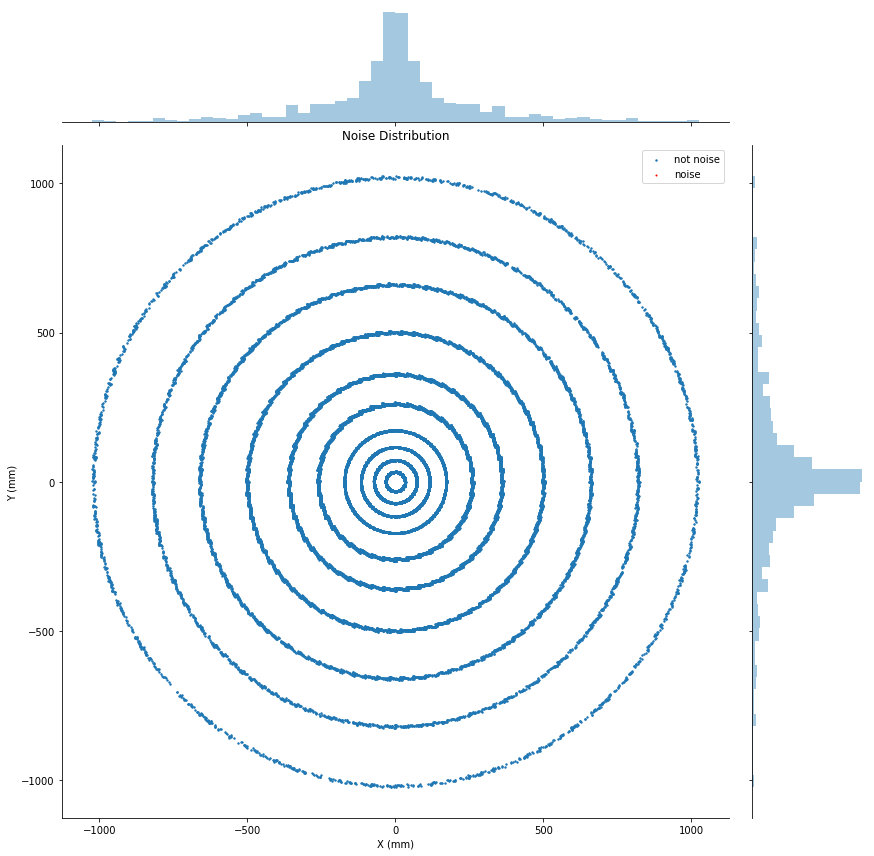

----0 Noise----
hits
(52482, 16)
truth
(52482, 9)
Not Noise Hits = 52482
Noise Hits = 0
len(neighbors[k]) = 596
Hits in the Neighborhood = 596
Hits outside the Neighborhood = 51886
Noise in Neighborhood = 0
Noise outside Neibhorhood = 0
----------------
% Hits inside = 0.011356274532220571
% Hits outside = 0.9886437254677795
% Noise inside = 0
% Noise outside = 0


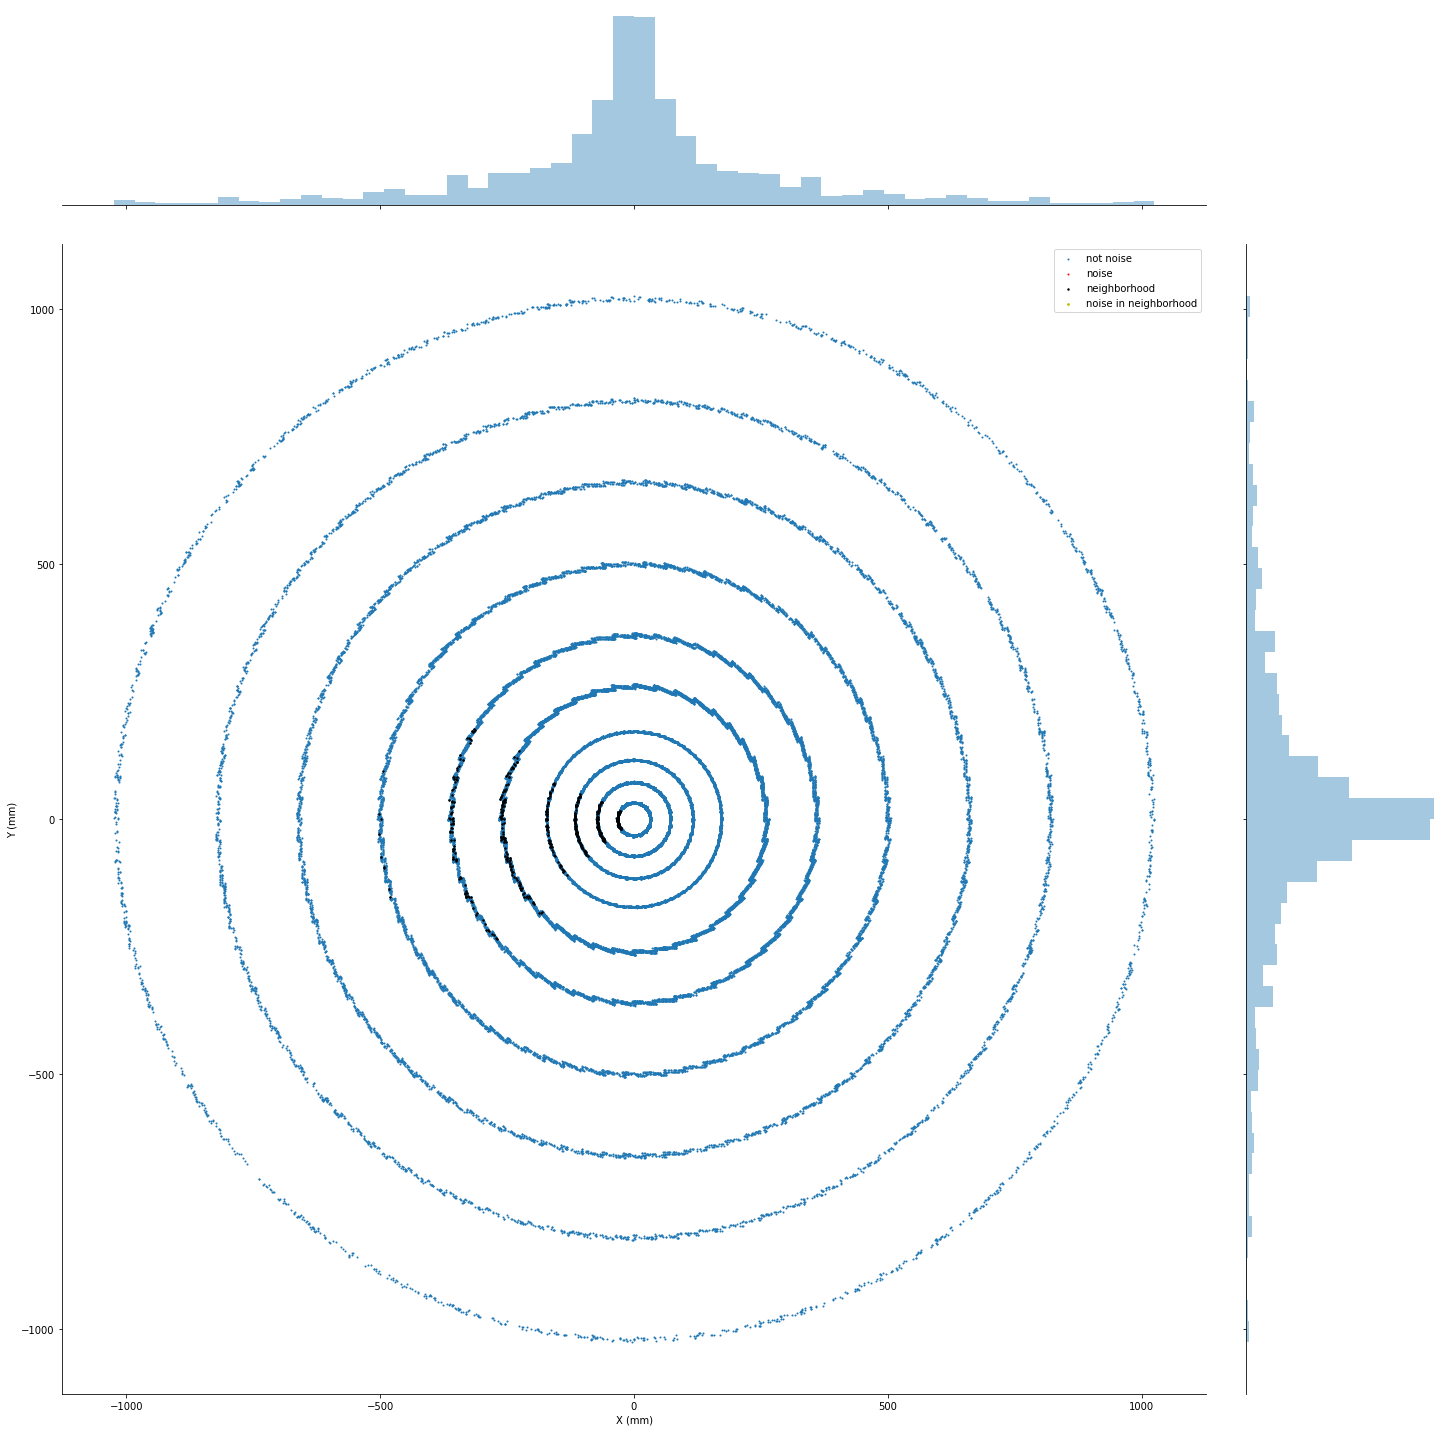

----0 Noise----
hits
(52482, 16)
truth
(52482, 9)
len(neighbors[k]) = 596
Hits in the Neighborhood = 596
Hits outside the Neighborhood = 51886
Noise in Neighborhood = 0


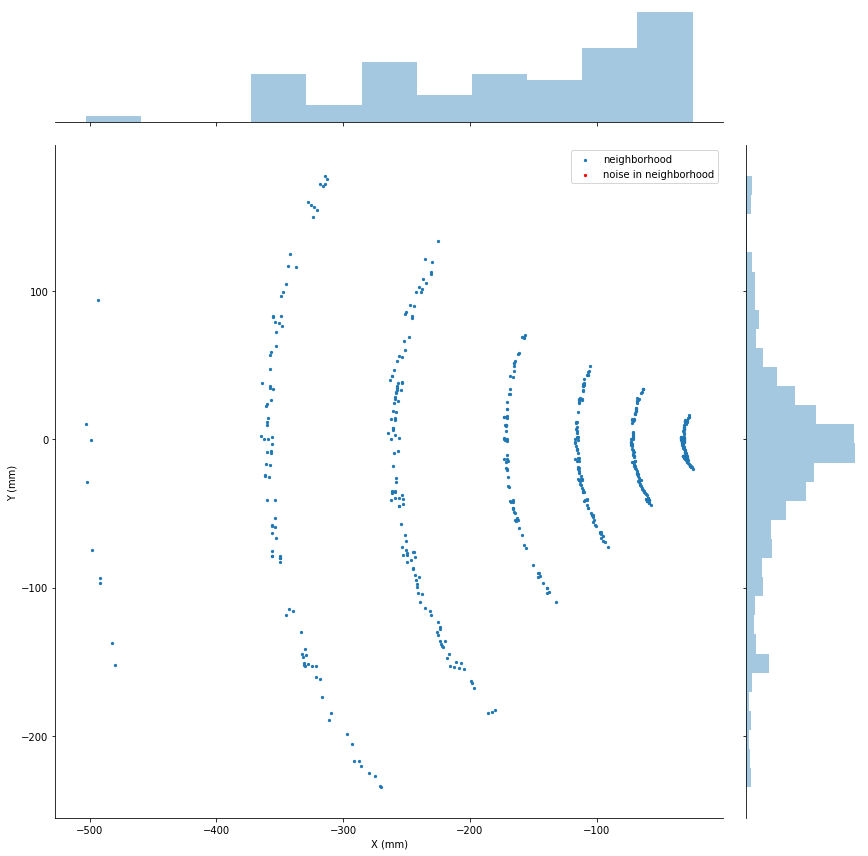

event: 0.2 number of hits: 55094
Total Neighborhoods/Hits = 55094
Chosen neighborhood/Hit = 0
----0.2 Noise----
hits
(55094, 16)
truth
(55094, 9)
Not Noise Hits = 52482
Noise Hits = 2612


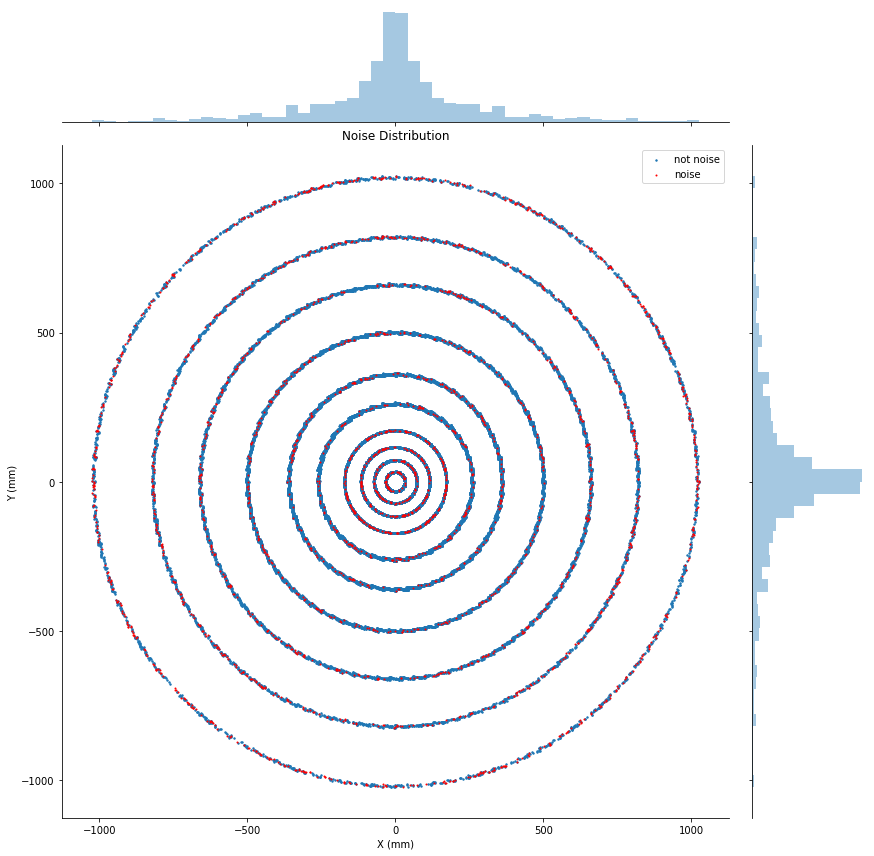

----0.2 Noise----
hits
(55094, 16)
truth
(55094, 9)
Not Noise Hits = 52482
Noise Hits = 2612
len(neighbors[k]) = 614
Hits in the Neighborhood = 614
Hits outside the Neighborhood = 54480
Noise in Neighborhood = 18
Noise outside Neibhorhood = 2594
----------------
% Hits inside = 0.011144589247467964
% Hits outside = 0.988855410752532
% Noise inside = 0.006891271056661562
% Noise outside = 0.04708316695102915


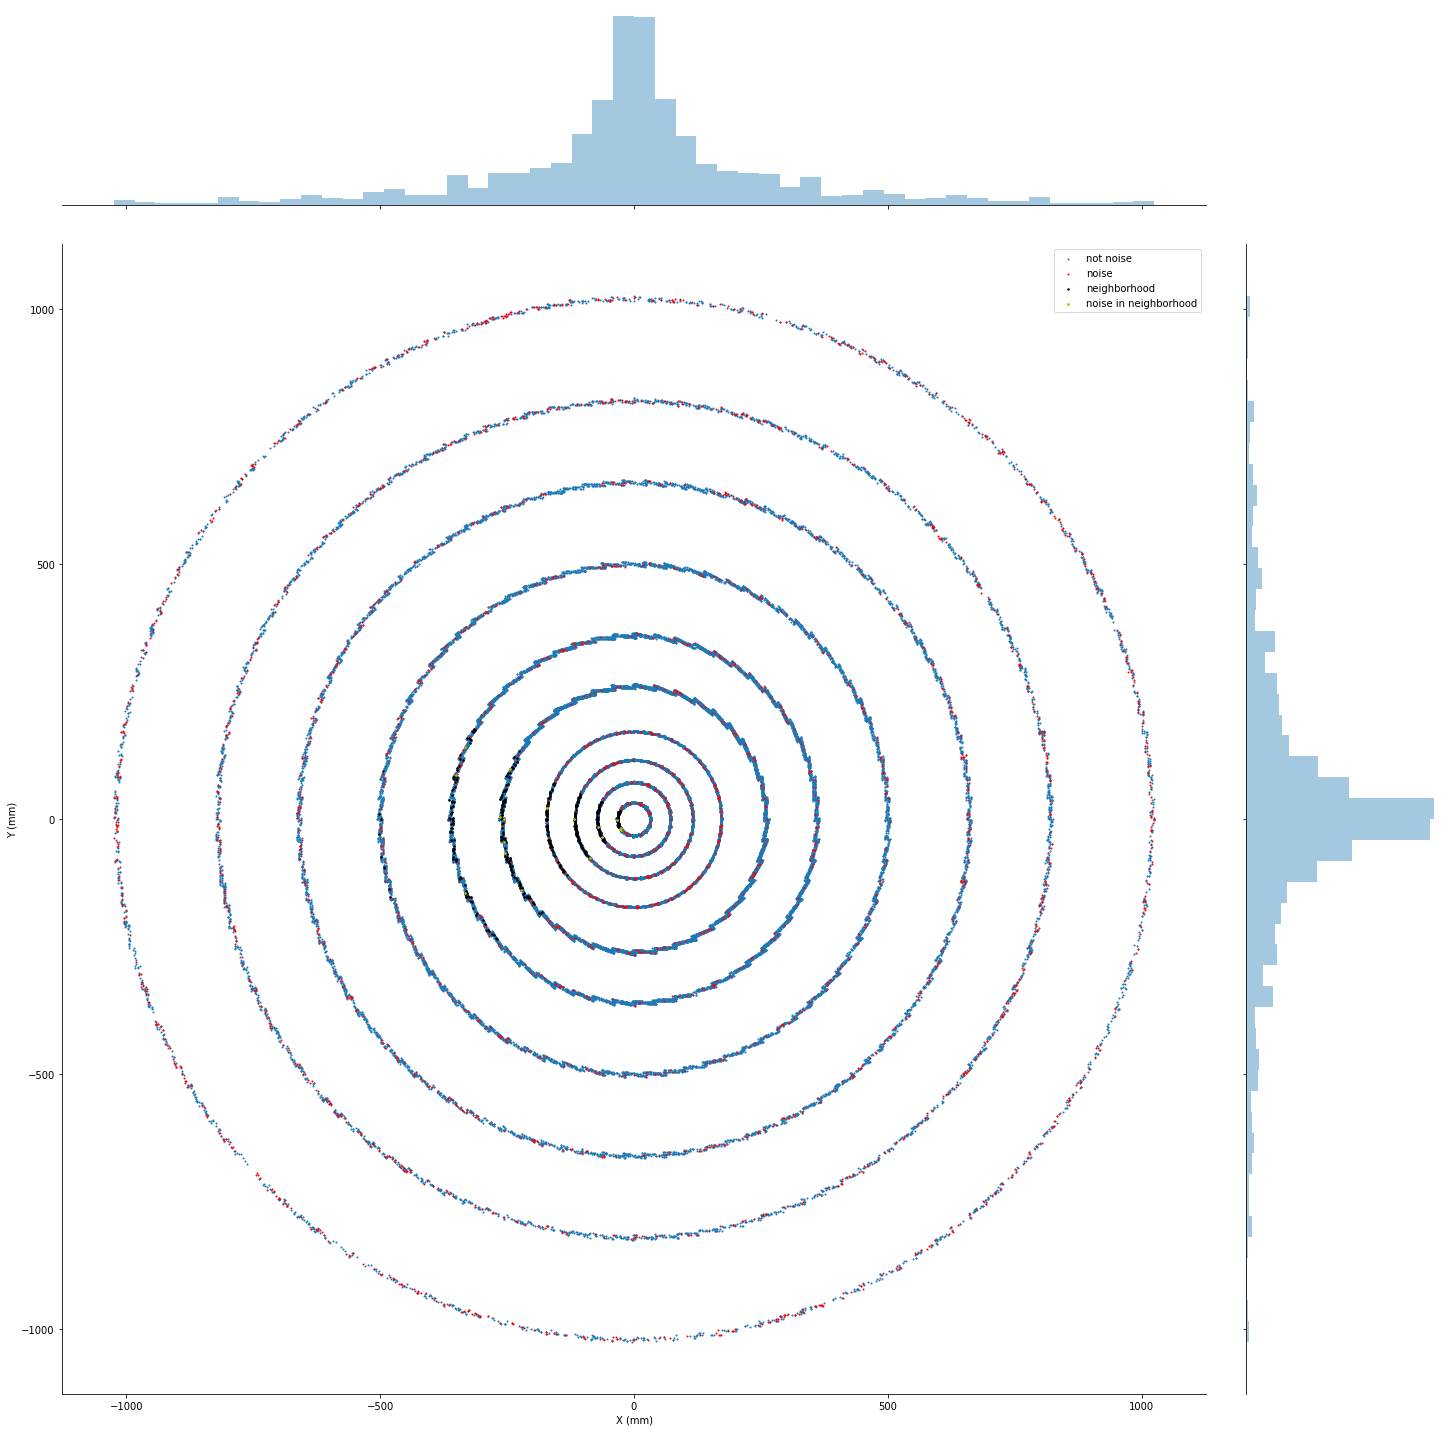

----0.2 Noise----
hits
(55094, 16)
truth
(55094, 9)
len(neighbors[k]) = 614
Hits in the Neighborhood = 614
Hits outside the Neighborhood = 54480
Noise in Neighborhood = 18


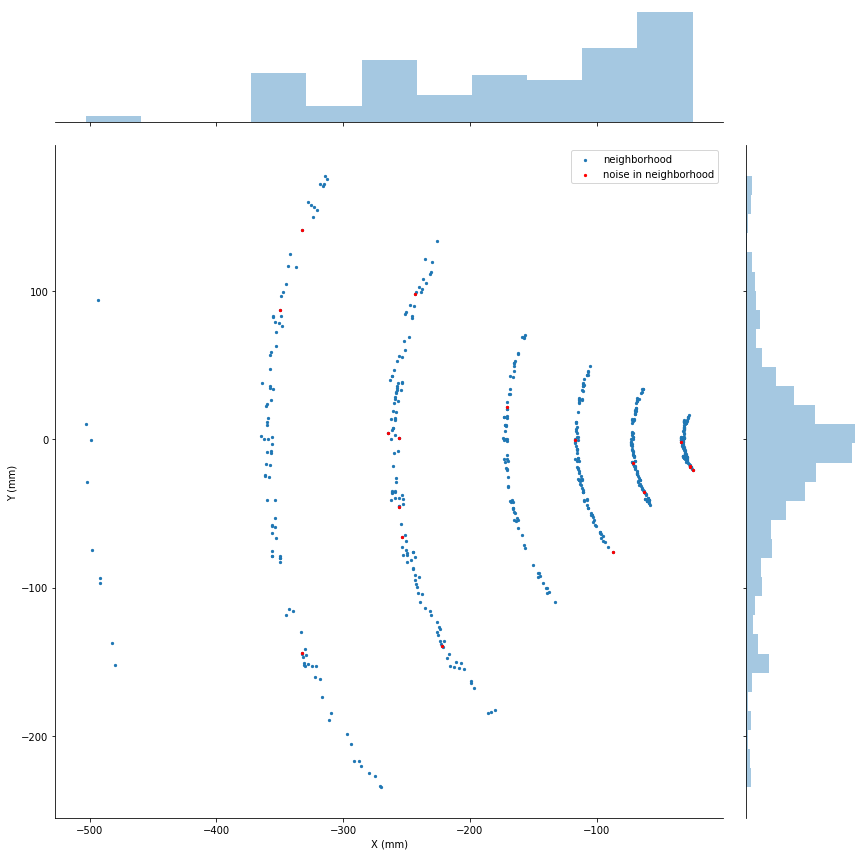

event: 0.4 number of hits: 57699
Total Neighborhoods/Hits = 57699
Chosen neighborhood/Hit = 0
----0.4 Noise----
hits
(57699, 16)
truth
(57699, 9)
Not Noise Hits = 52482
Noise Hits = 5217


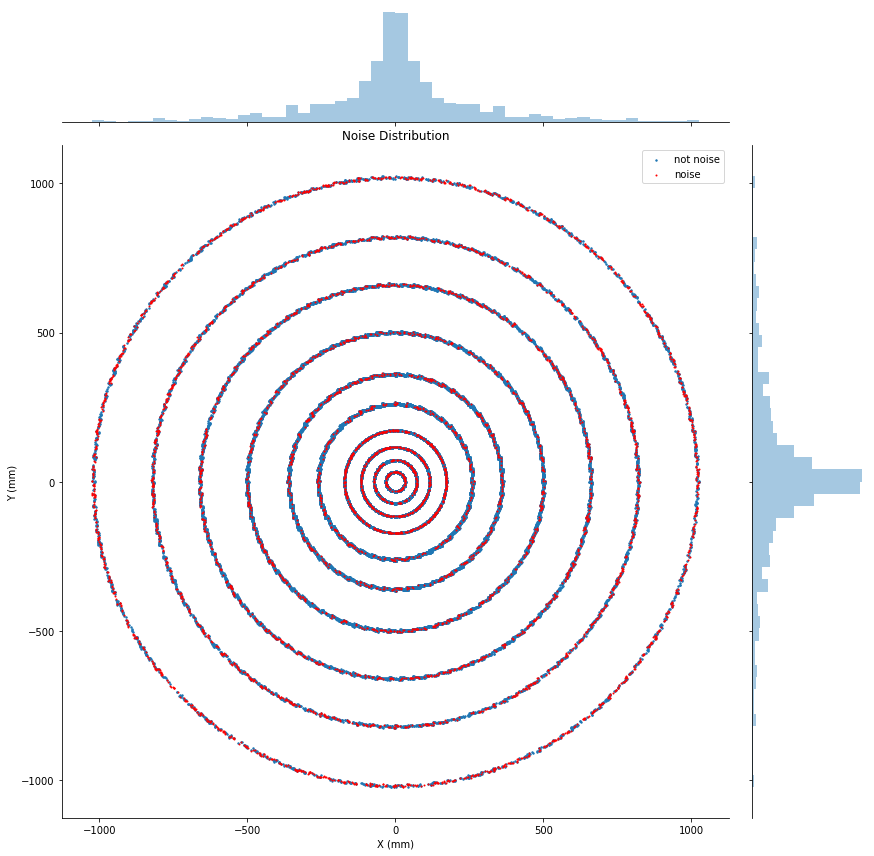

----0.4 Noise----
hits
(57699, 16)
truth
(57699, 9)
Not Noise Hits = 52482
Noise Hits = 5217
len(neighbors[k]) = 631
Hits in the Neighborhood = 631
Hits outside the Neighborhood = 57068
Noise in Neighborhood = 35
Noise outside Neibhorhood = 5182
----------------
% Hits inside = 0.010936064749822354
% Hits outside = 0.9890639352501777
% Noise inside = 0.006708836496070539
% Noise outside = 0.08981091526716234


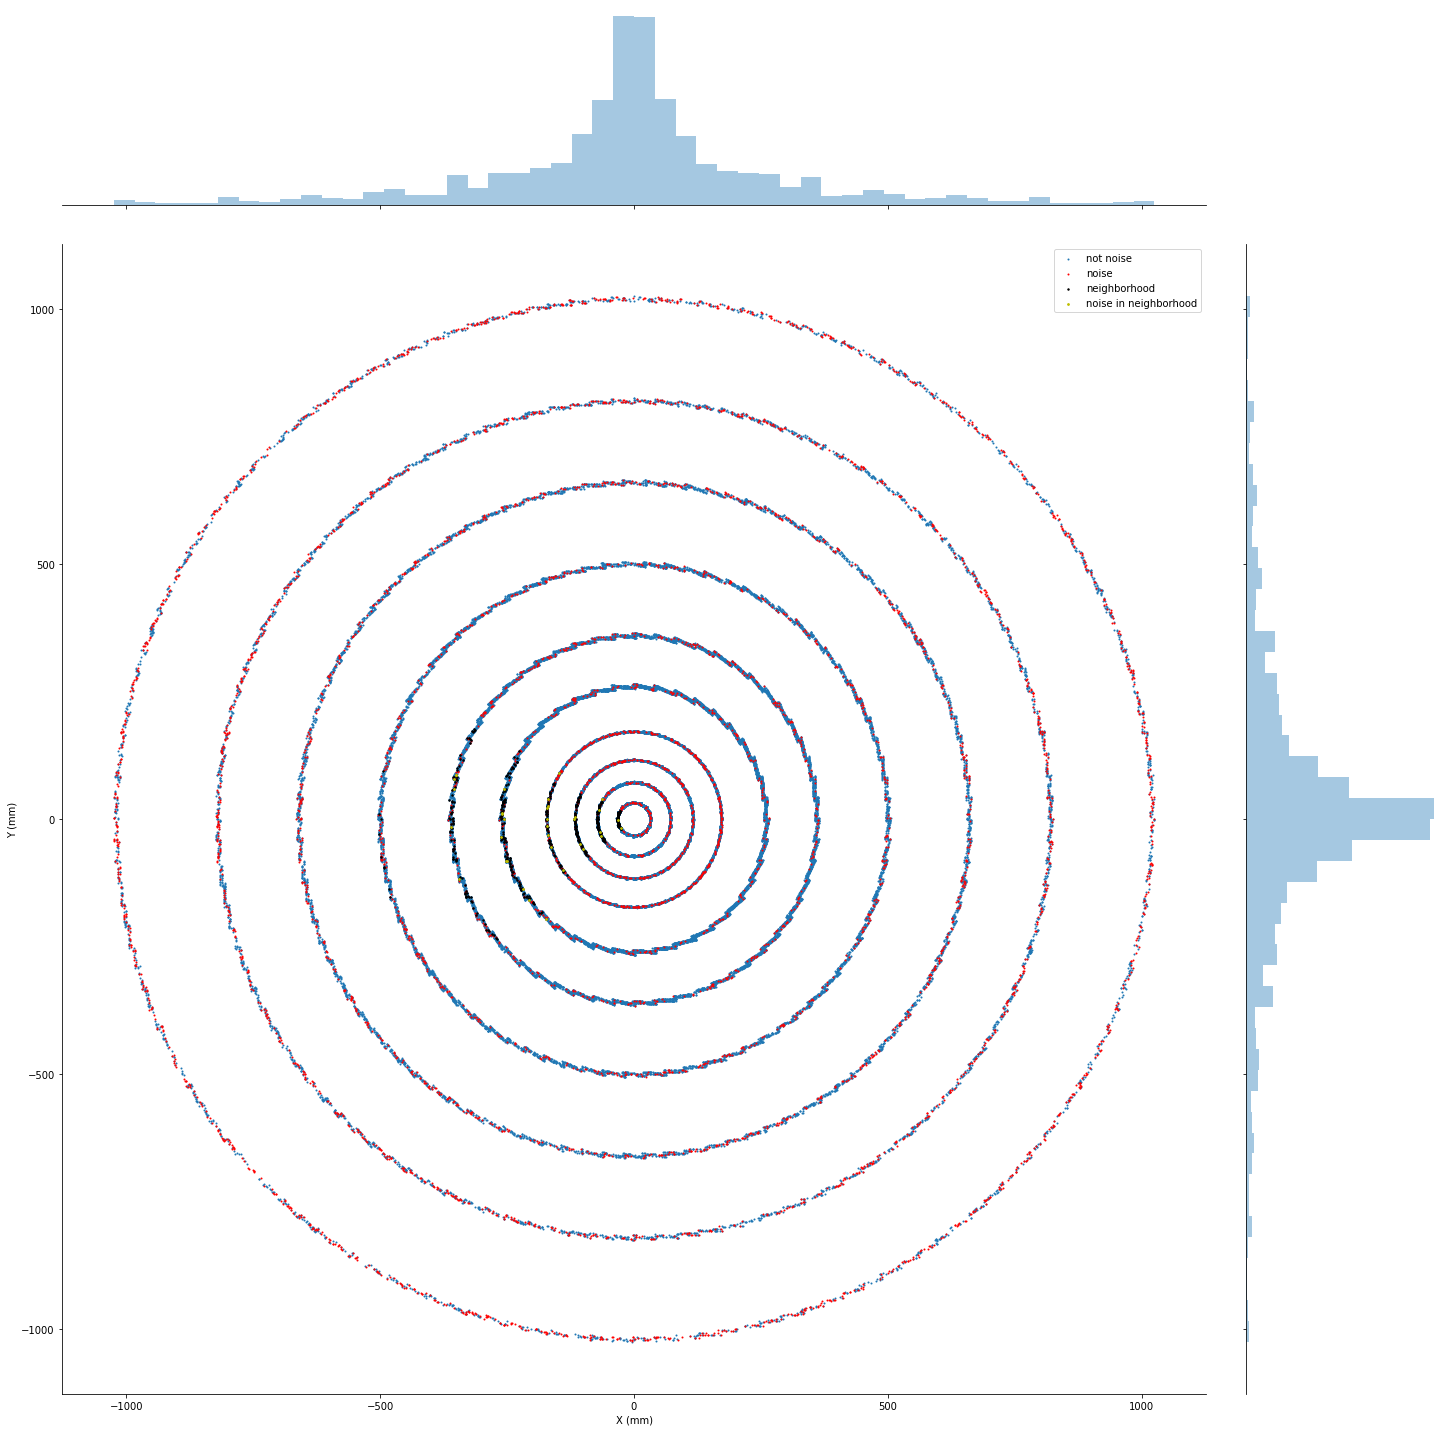

----0.4 Noise----
hits
(57699, 16)
truth
(57699, 9)
len(neighbors[k]) = 631
Hits in the Neighborhood = 631
Hits outside the Neighborhood = 57068
Noise in Neighborhood = 35


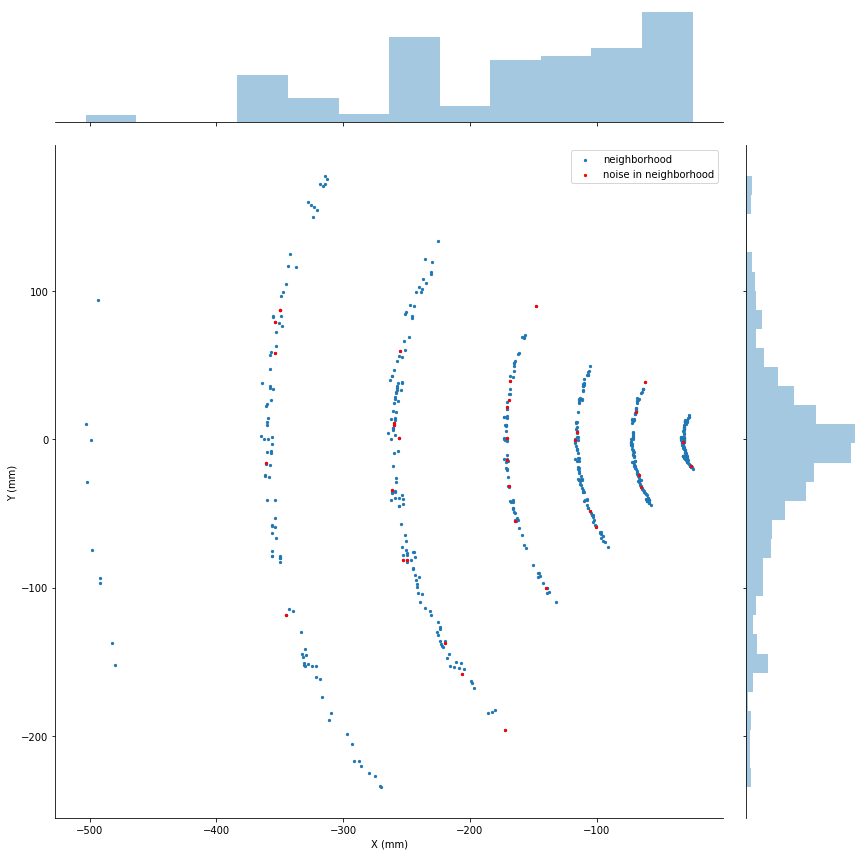

event: 0.6 number of hits: 60314
Total Neighborhoods/Hits = 60314
Chosen neighborhood/Hit = 0
----0.6 Noise----
hits
(60314, 16)
truth
(60314, 9)
Not Noise Hits = 52482
Noise Hits = 7832


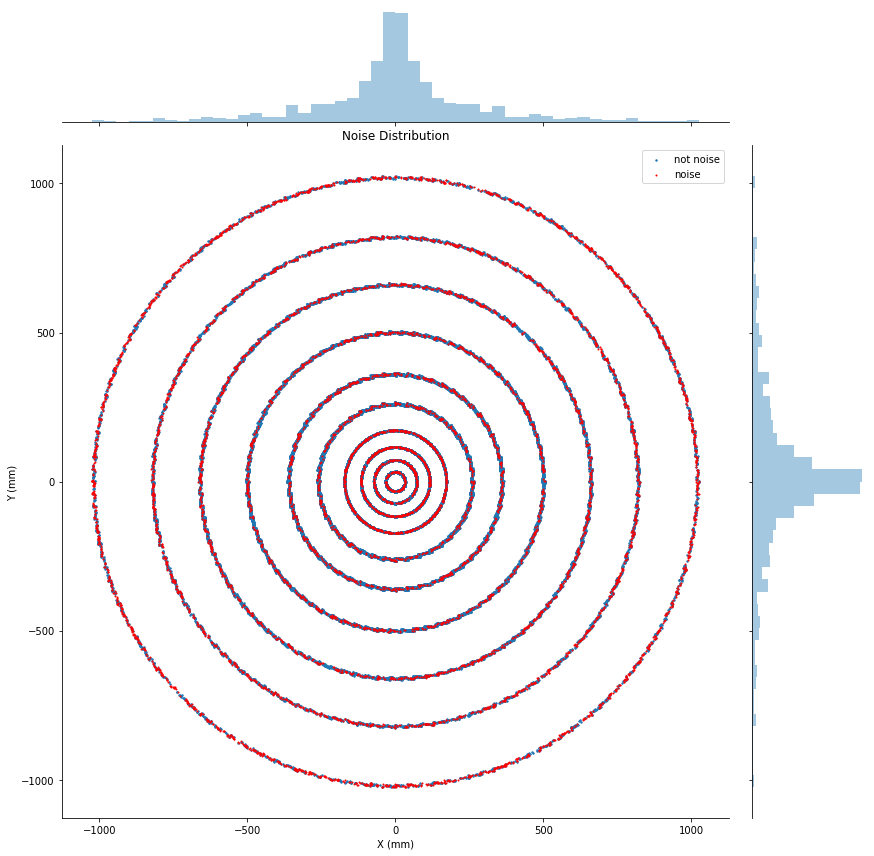

----0.6 Noise----
hits
(60314, 16)
truth
(60314, 9)
Not Noise Hits = 52482
Noise Hits = 7832
len(neighbors[k]) = 648
Hits in the Neighborhood = 648
Hits outside the Neighborhood = 59666
Noise in Neighborhood = 52
Noise outside Neibhorhood = 7780
----------------
% Hits inside = 0.010743774248101601
% Hits outside = 0.9892562257518984
% Noise inside = 0.006639427987742594
% Noise outside = 0.1289916105713433


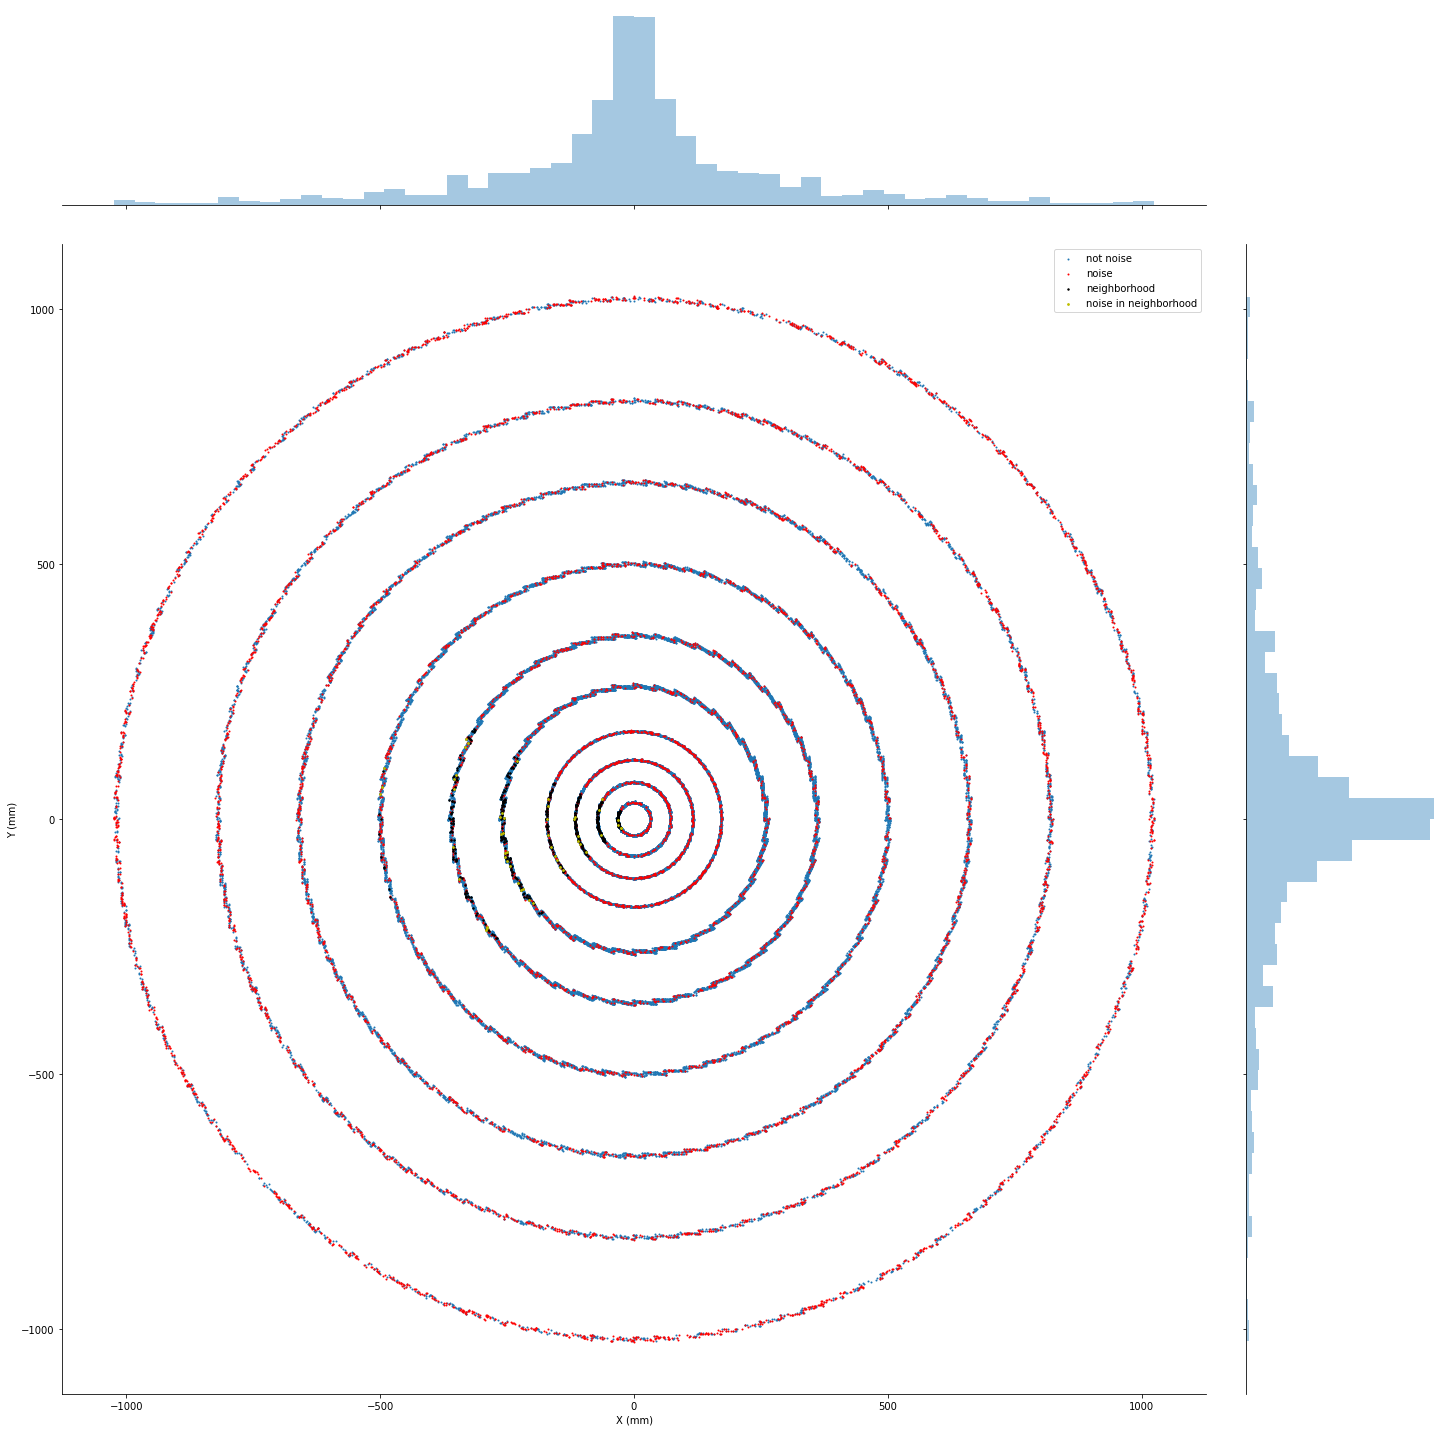

----0.6 Noise----
hits
(60314, 16)
truth
(60314, 9)
len(neighbors[k]) = 648
Hits in the Neighborhood = 648
Hits outside the Neighborhood = 59666
Noise in Neighborhood = 52


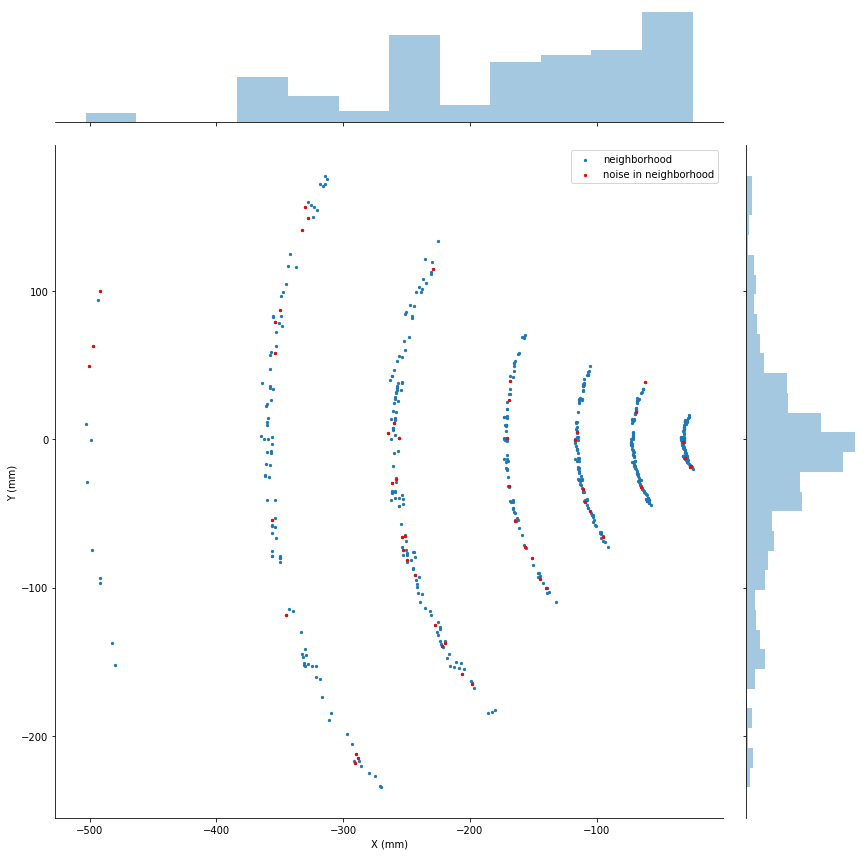

event: 0.8 number of hits: 62859
Total Neighborhoods/Hits = 62859
Chosen neighborhood/Hit = 0
----0.8 Noise----
hits
(62859, 16)
truth
(62859, 9)
Not Noise Hits = 52482
Noise Hits = 10377


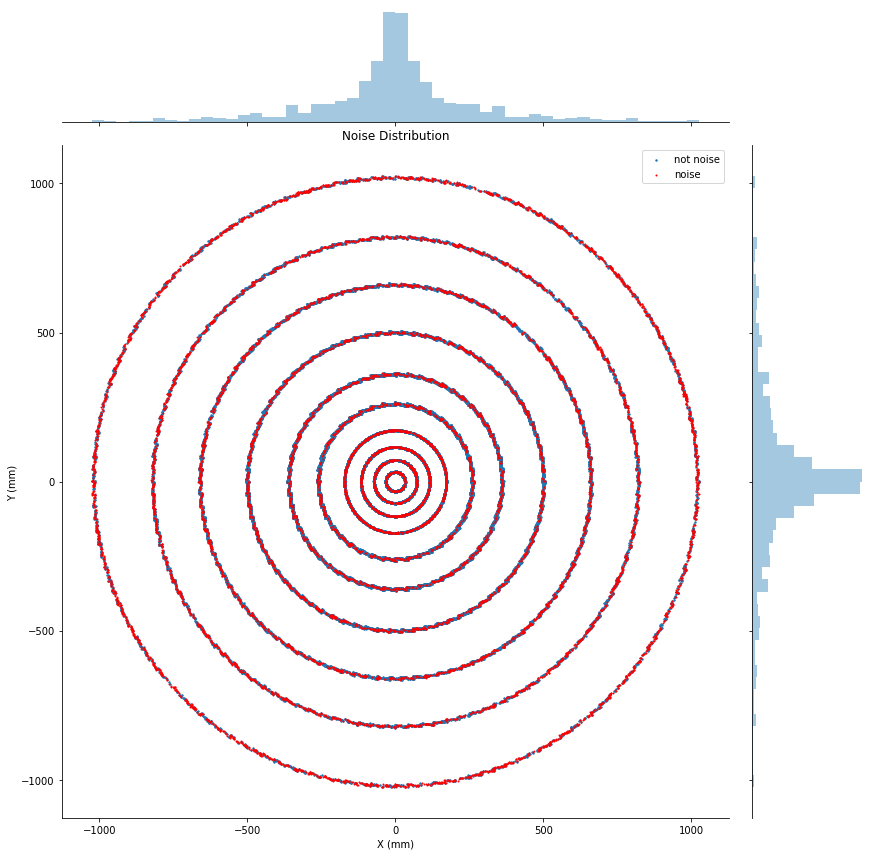

----0.8 Noise----
hits
(62859, 16)
truth
(62859, 9)
Not Noise Hits = 52482
Noise Hits = 10377
len(neighbors[k]) = 666
Hits in the Neighborhood = 666
Hits outside the Neighborhood = 62193
Noise in Neighborhood = 70
Noise outside Neibhorhood = 10307
----------------
% Hits inside = 0.010595141507182743
% Hits outside = 0.9894048584928172
% Noise inside = 0.00674568757829816
% Noise outside = 0.163970155427226


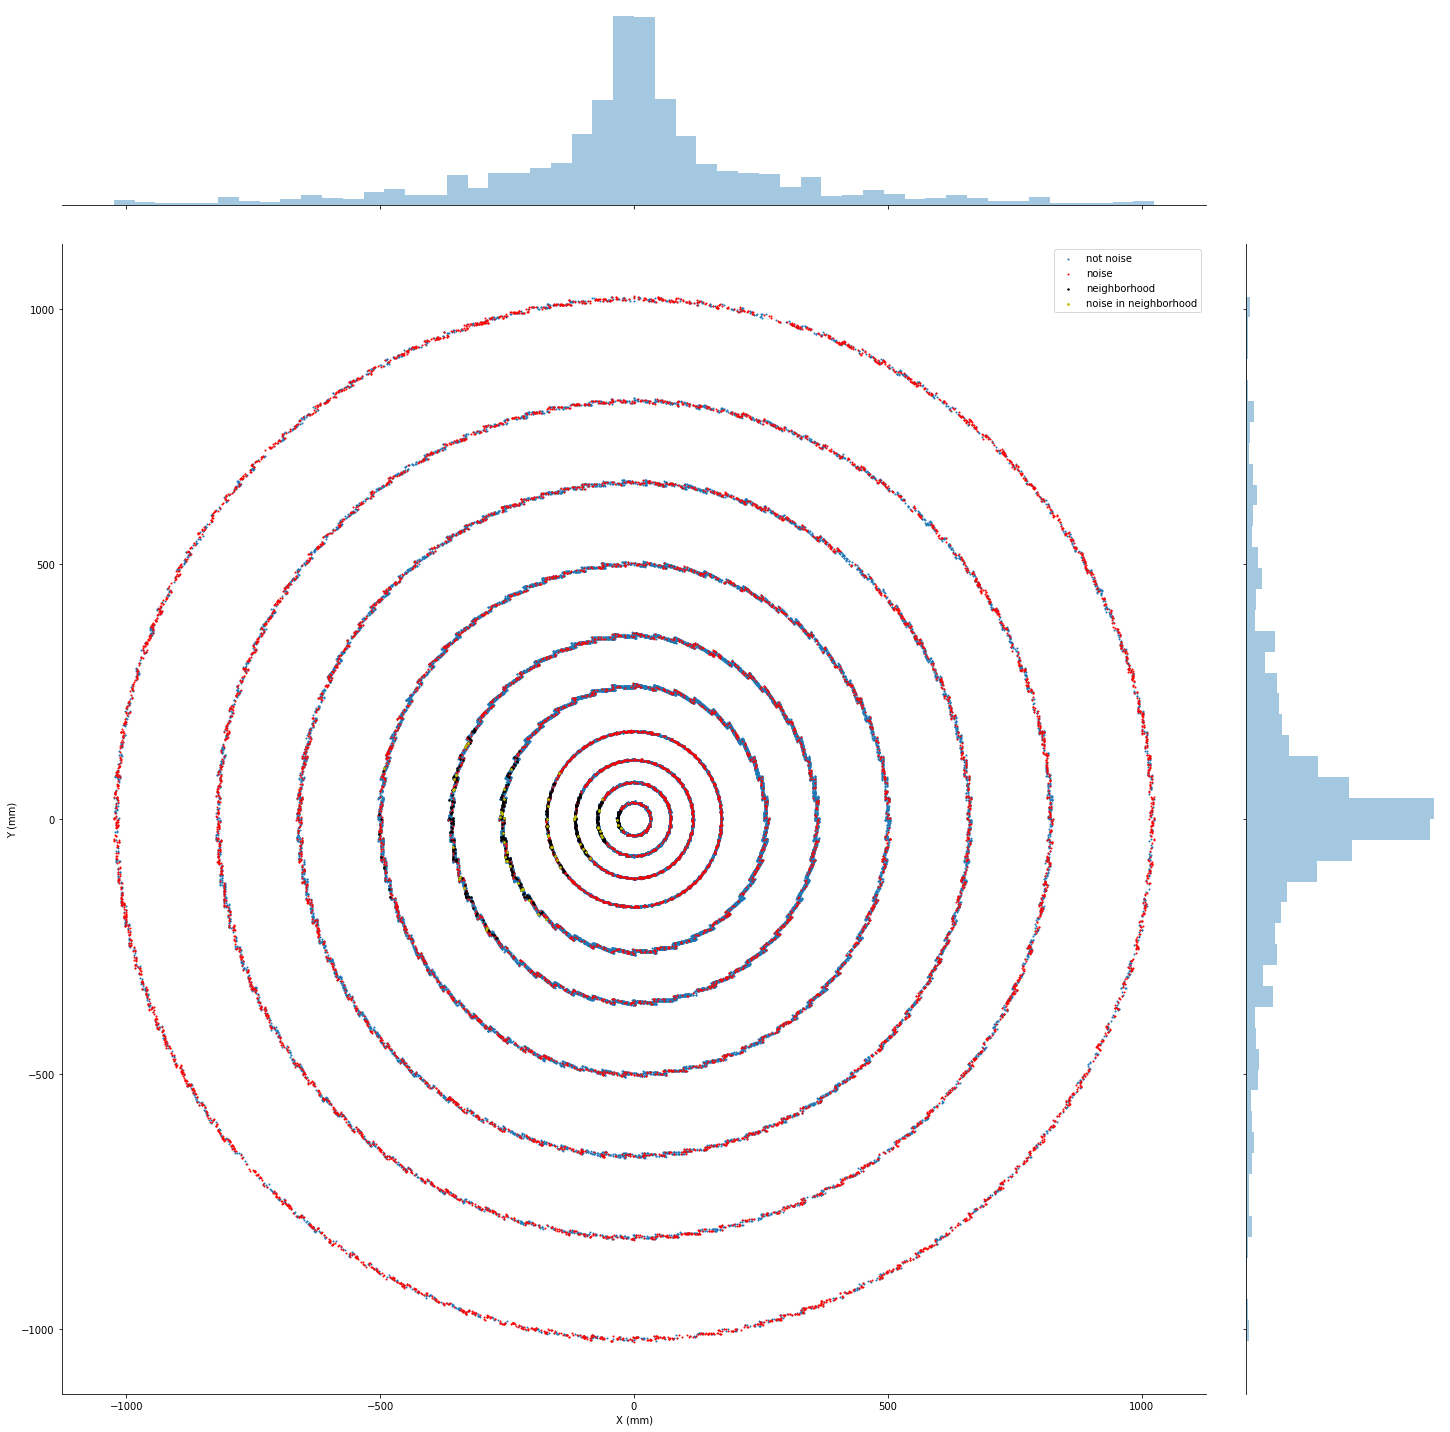

----0.8 Noise----
hits
(62859, 16)
truth
(62859, 9)
len(neighbors[k]) = 666
Hits in the Neighborhood = 666
Hits outside the Neighborhood = 62193
Noise in Neighborhood = 70


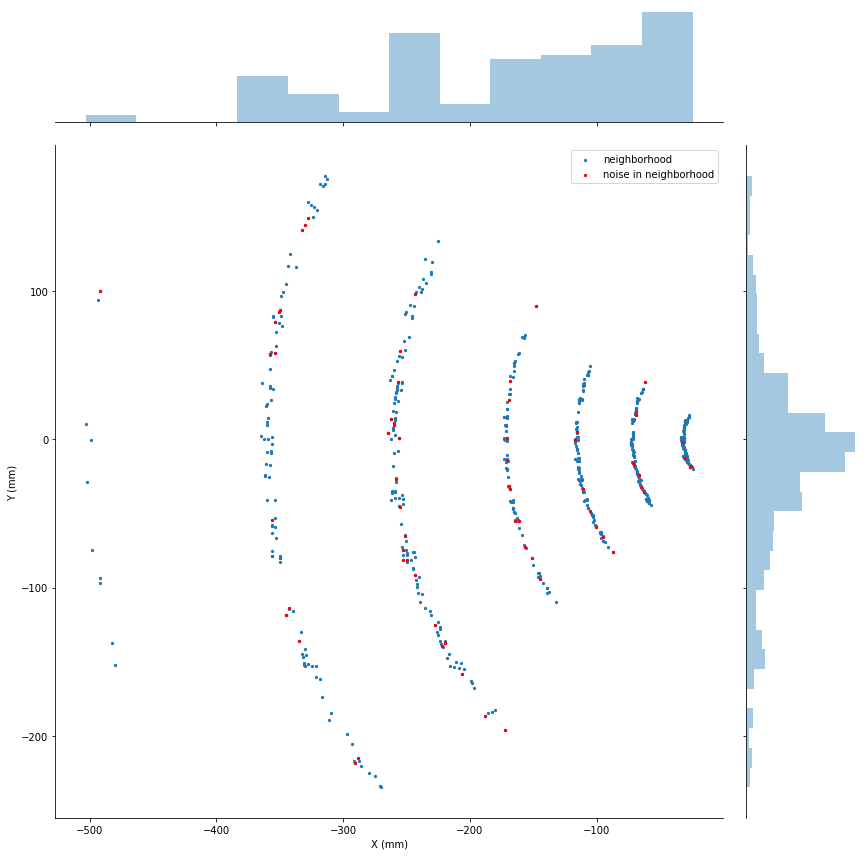

event: 1 number of hits: 65518
Total Neighborhoods/Hits = 65518
Chosen neighborhood/Hit = 0
----1 Noise----
hits
(65518, 16)
truth
(65518, 9)
Not Noise Hits = 52482
Noise Hits = 13036


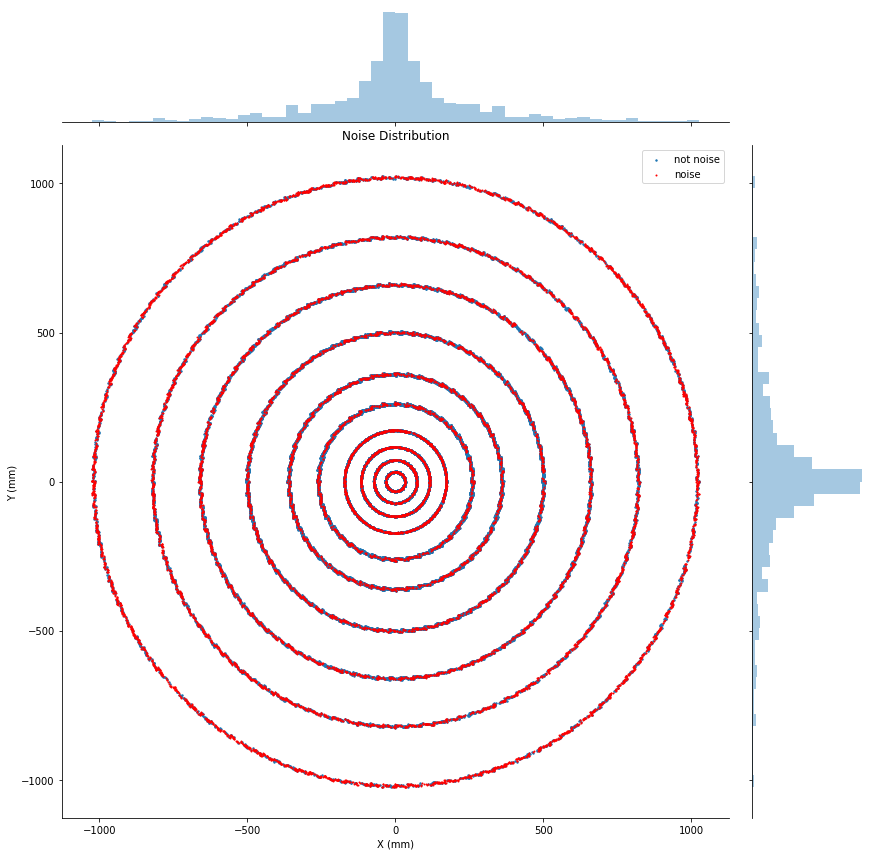

----1 Noise----
hits
(65518, 16)
truth
(65518, 9)
Not Noise Hits = 52482
Noise Hits = 13036
len(neighbors[k]) = 687
Hits in the Neighborhood = 687
Hits outside the Neighborhood = 64831
Noise in Neighborhood = 91
Noise outside Neibhorhood = 12945
----------------
% Hits inside = 0.010485668060685613
% Hits outside = 0.9895143319393144
% Noise inside = 0.006980668916845658
% Noise outside = 0.19757929118715467


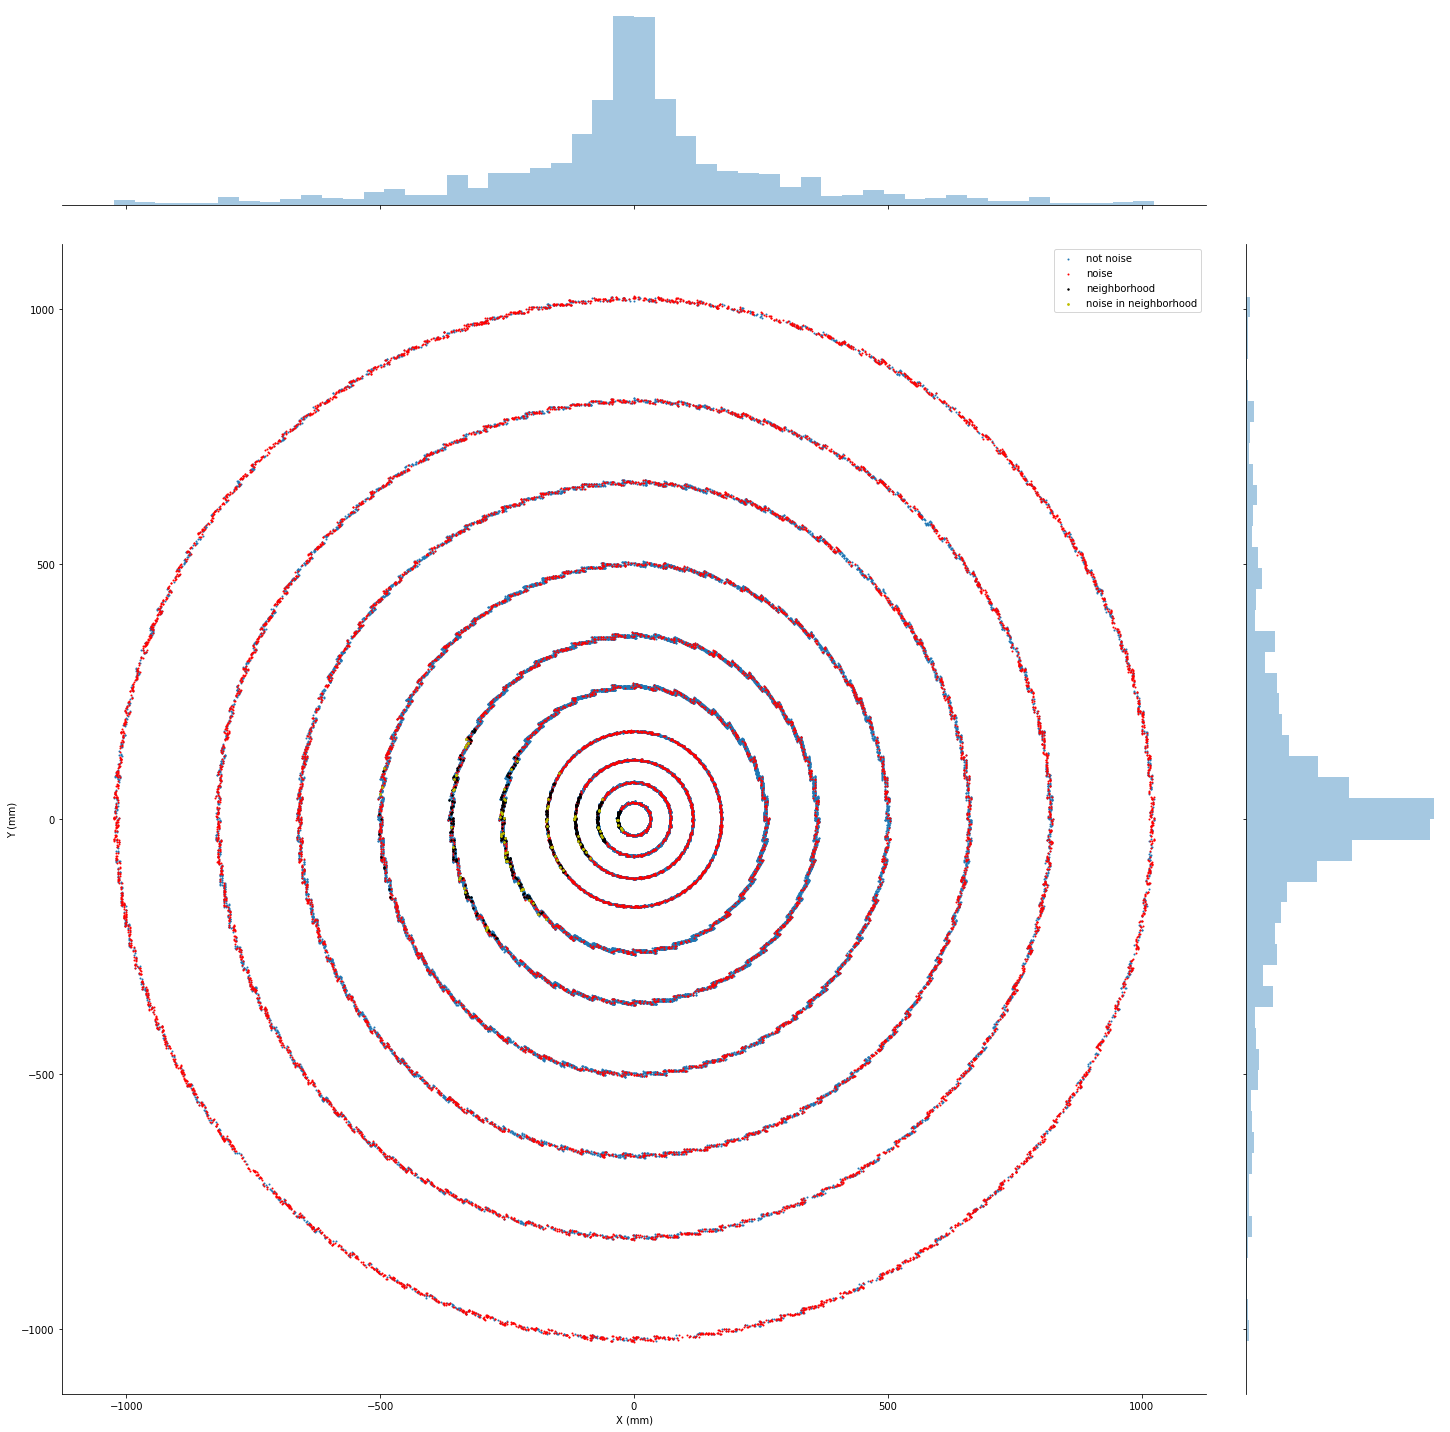

----1 Noise----
hits
(65518, 16)
truth
(65518, 9)
len(neighbors[k]) = 687
Hits in the Neighborhood = 687
Hits outside the Neighborhood = 64831
Noise in Neighborhood = 91


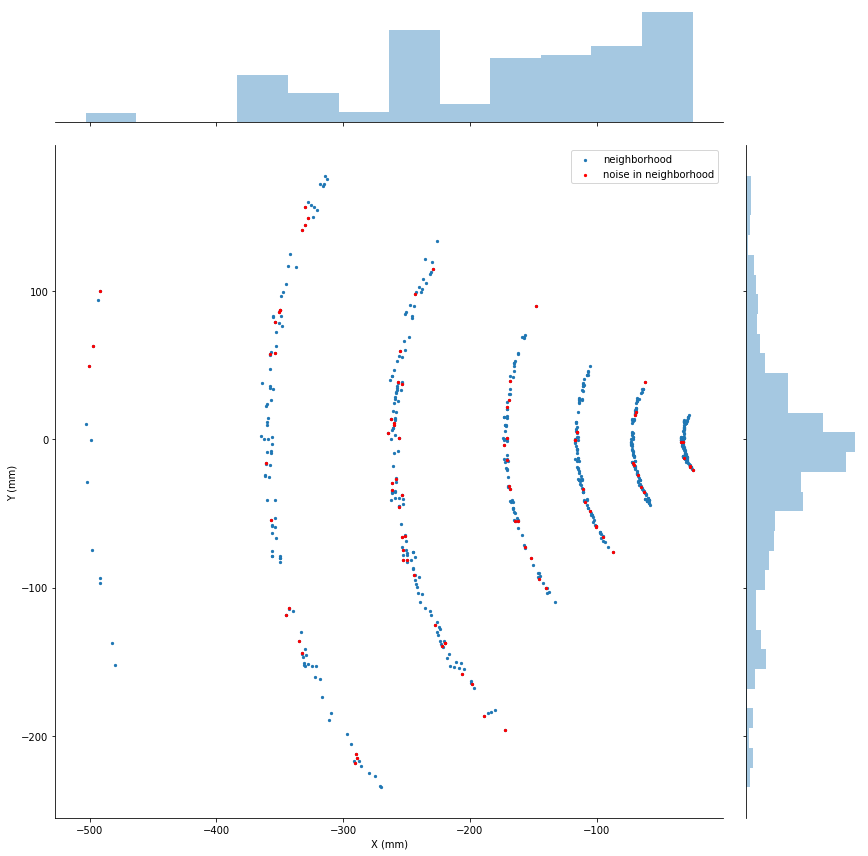

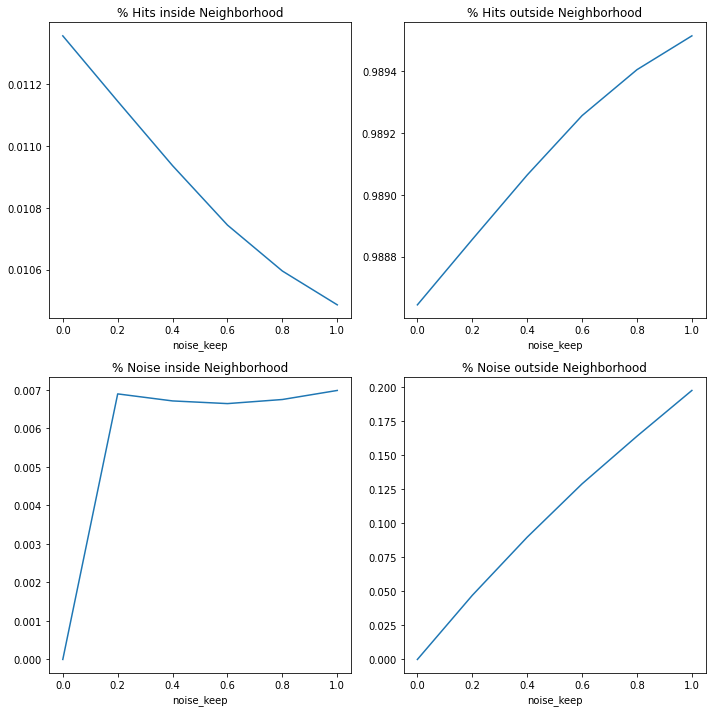

In [10]:
overall(0)

In [34]:
from tqdm import tqdm
import statistics
def ratios(hits, truth, feature_names, noise_keep, emb_model,radius=0.4):
    neighbors = get_emb_neighbors(hits[feature_names].values, emb_model, radius)
    print("----" + str(noise_keep) + " Noise----")
    print("hits")
    print(hits.shape)
    print("truth")
    print(truth.shape)

    unique_ids = truth.particle_id.unique()
    track_ids_to_keep = unique_ids[np.where(unique_ids != 0)]
    where_to_keep = truth['particle_id'].isin(track_ids_to_keep)
    not_noise  = hits[where_to_keep]
    noise = hits[~where_to_keep]
    print("Not Noise Hits = " + str(len(not_noise)))
    print("Noise Hits = " + str(len(noise)))
    
    truth_np = np.array(truth.values)
    in_hits =[]
    out_hits =[]
    in_noise =[]
    out_noise =[]
        
    n_nbr = len(neighbors)
    for nbr in tqdm(range(n_nbr)):
        hood = neighbors[nbr]
        in_h = len(hood)/len(hits)
        out_h = (len(hits)-len(hood))/len(hits)
        in_hits.append(in_h)
        out_hits.append(out_h)
        noise_count = 0
        if (len(noise) == 0):
            in_noise =[]
            out_noise =[]
            in_noise_mean = 0 
            out_noise_mean = 0
        else:
            for hit in hood:
                if truth_np[hit, 1] == 0: noise_count+=1
            in_n = noise_count/len(noise)
            out_n = (len(noise) - noise_count)/len(noise)
            in_noise.append(in_n)
            out_noise.append(out_n)
            
    if(len(noise)!=0):
        in_noise_mean = statistics.mean(in_noise)
        out_noise_mean = statistics.mean(out_noise)
        
    return statistics.mean(in_hits), statistics.mean(out_hits), in_noise_mean, out_noise_mean
    

In [43]:
def overall_ratios():
    feature_names = ['x', 'y', 'z', 'cell_count', 'cell_val', 'leta', 'lphi', 'lx', 'ly', 'lz', 'geta', 'gphi']
    noise_keeps = ["0", "0.2", "0.4", "0.6", "0.8", "1"]
    
    in_hits =[]
    out_hits =[]
    in_noise=[]
    out_noise =[]
    
    for noise_keep in noise_keeps:
        hits, truth, emb_model = get_data(noise_keep)
        in_h, out_h, in_n, out_n = ratios(hits, truth, feature_names,noise_keep, emb_model,0.4)
        in_hits.append(in_h)
        out_hits.append(out_h)
        in_noise.append(in_n)
        out_noise.append(out_n)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,10))
    x = [float(keep) for keep in noise_keeps]
    ax1.plot(x, in_hits)
    ax1.set_title("% Hits inside Neighborhood")
    ax1.set_xlabel("noise_keep")
    ax2.plot(x, out_hits)
    ax2.set_title("% Hits outside Neighborhood")
    ax2.set_xlabel("noise_keep")
    
    in_noise.pop(0)
    out_noise.pop(0)
    noise_keepsn = ["0.2", "0.4", "0.6", "0.8", "1"]
    xn = [float(keep) for keep in noise_keepsn]
    ax3.plot(xn, in_noise)
    ax3.set_title("% Noise inside Neighborhood")
    ax3.set_xlabel("noise_keep")
    ax4.plot(xn, out_noise)
    ax4.set_title("% Noise outside Neighborhood")
    ax4.set_xlabel("noise_keep")
    
    plt.savefig("overall_allhits.png", bbox_inches='tight')
    plt.tight_layout()
        

event: 0 number of hits: 52482


100%|██████████| 52482/52482 [00:00<00:00, 451187.72it/s]

----0 Noise----
hits
(52482, 16)
truth
(52482, 9)
Not Noise Hits = 52482
Noise Hits = 0


event: 0.2 number of hits: 55094


  1%|▏         | 741/55094 [00:00<00:07, 7397.57it/s]

----0.2 Noise----
hits
(55094, 16)
truth
(55094, 9)
Not Noise Hits = 52482
Noise Hits = 2612


100%|██████████| 55094/55094 [00:23<00:00, 2319.55it/s]


event: 0.4 number of hits: 57699


  1%|▏         | 744/57699 [00:00<00:07, 7434.30it/s]

----0.4 Noise----
hits
(57699, 16)
truth
(57699, 9)
Not Noise Hits = 52482
Noise Hits = 5217


100%|██████████| 57699/57699 [00:26<00:00, 2195.50it/s]


event: 0.6 number of hits: 60314


  1%|          | 723/60314 [00:00<00:08, 7217.67it/s]

----0.6 Noise----
hits
(60314, 16)
truth
(60314, 9)
Not Noise Hits = 52482
Noise Hits = 7832


100%|██████████| 60314/60314 [00:28<00:00, 2085.42it/s]


event: 0.8 number of hits: 62859


  1%|          | 525/62859 [00:00<00:11, 5229.32it/s]

----0.8 Noise----
hits
(62859, 16)
truth
(62859, 9)
Not Noise Hits = 52482
Noise Hits = 10377


100%|██████████| 62859/62859 [00:31<00:00, 1990.32it/s]


event: 1 number of hits: 65518


  1%|          | 678/65518 [00:00<00:09, 6754.47it/s]

----1 Noise----
hits
(65518, 16)
truth
(65518, 9)
Not Noise Hits = 52482
Noise Hits = 13036


100%|██████████| 65518/65518 [00:35<00:00, 1871.57it/s]


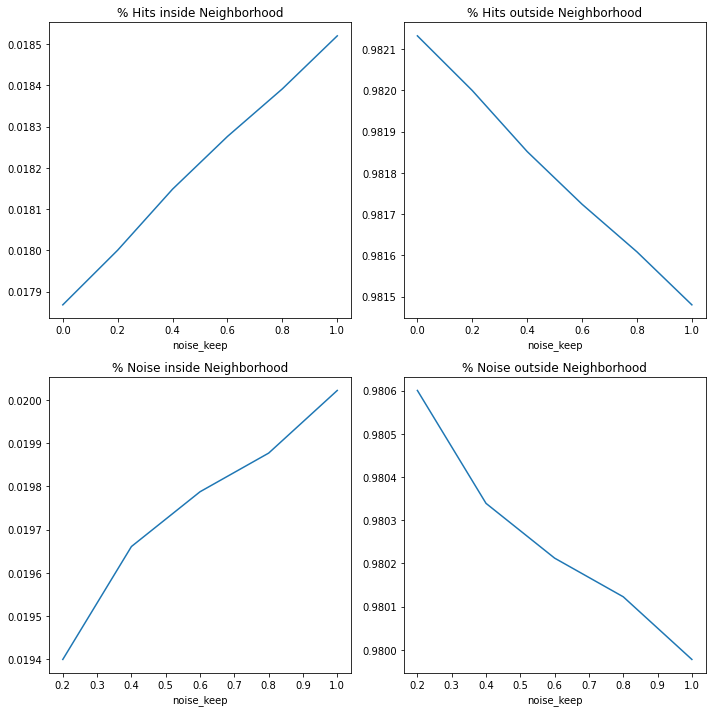

In [44]:
overall_ratios()